In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ipl-complete-dataset-20082020:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F990900%2F8637500%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240702%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240702T115608Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dfbb01fbeba8efdb738d233adedf08e033d447ed82e75ed1b064dee4e9547124a0ef9ced823deec49f42f98dcf743b6af08893448ad1fe175ccab0688574094c4bb8adf0c27aeca1c6efd4399bf1055c41c11997427979f1da0d956d87b67cf32e9b3c59e5bad480fc6e7767c36278538948a566cfabe6f5da7c3881256fc90e5d10236b3dceaa7fbaf2924be129b08441e5cf504ac915ee7124557aede032ec800345f9c569c98313d947f1b880f3635f0775efd7089363060d50edb9d6eafc6c7177df5c4632626b80e5a7b7fef4ce4e149bcc008e39ff2f92b99559c7b4506cfacccb3d04d9a52e4cdb9ca4dbbfadb4575515926767bb981983f7c8886b4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1910090 bytes downloaded
Downloaded and uncompressed: ipl-complete-dataset-20082020
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-complete-dataset-20082020/deliveries.csv
/kaggle/input/ipl-complete-dataset-20082020/matches.csv


In [ ]:
pd.set_option('display.max_columns', None)

# Importing modules

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Loading the dataset

In [ ]:
mdf = pd.read_csv('/kaggle/input/ipl-complete-dataset-20082020/matches.csv')
mdf.shape

(1095, 20)

Matches data will be used when we need to predict the winner before the match (maybe for seeding), whereas deliveries data will be used when we need to predict real time live scores as the match is happening.

The goal is to make two models, one for Match Outcome Prediction and another for Live Score Prediction.

In [ ]:
mdf.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


# Data analysis and Pre-processing

In [ ]:
mdf_clone = mdf.copy() # Just in case.

The dataset seems to balanced enough with respect to the number of instances in each target class.

In [ ]:
team1_win_count = len(mdf.loc[mdf['team1'] == mdf['winner']])
team2_win_count = len(mdf.loc[mdf['team2'] == mdf['winner']])
team1_win_count, team2_win_count

(555, 535)

Adding timeseries features to take into consideration the seasonal patterns as well.

In [ ]:
mdf['dayofyear'] = pd.to_datetime(mdf['date']).dt.dayofyear
mdf['dayofweek'] = pd.to_datetime(mdf['date']).dt.dayofweek
mdf['season'] = pd.to_datetime(mdf['date']).dt.year

We don't need this anymore, so we can drop this feature.

In [ ]:
mdf = mdf.drop(columns=['date'])

Since this dataset has data on matches that happened throughout several years, it has different team names for some of the teams. So we map all of them to simply the city name. This makes it easier to also check if the teams are on home ground.

In [ ]:
team_city_map = {
    'Sunrisers Hyderabad': 'Hyderabad',
    'Deccan Chargers': 'Hyderabad',
    'Mumbai Indians': 'Mumbai',
    'Gujarat Lions': 'Gujarat',
    'Gujarat Titans': 'Gujarat',
    'Rising Pune Supergiants': 'Pune',
    'Rising Pune Supergiant': 'Pune',
    'Pune Warriors': 'Pune',
    'Royal Challengers Bangalore': 'Bangalore',
    'Royal Challengers Bengaluru': 'Bangalore',
    'Kolkata Knight Riders': 'Kolkata',
    'Delhi Daredevils': 'Delhi',
    'Delhi Capitals': 'Delhi',
    'Kings XI Punjab': 'Punjab',
    'Punjab Kings': 'Punjab',
    'Chennai Super Kings': 'Chennai',
    'Rajasthan Royals': 'Rajasthan',
    'Kochi Tuskers Kerala': 'Kochi',
    'Lucknow Super Giants': 'Lucknow'
}

def team_to_city(df, feature):
    df[feature] = df[feature].map(team_city_map)
    return df

def map_team_city(df):
    mdf = df.copy()
    for feature in ['team1', 'team2', 'toss_winner', 'winner']:
        if feature in mdf.columns:
            mdf = team_to_city(mdf, feature)
    return mdf

mdf = map_team_city(mdf)

Checking for home ground advantage.

In [ ]:
mdf['team1_home'] = False
mdf['team2_home'] = False

mdf.loc[mdf['city'] == mdf['team1'], 'team1_home'] = True
mdf.loc[mdf['city'] == mdf['team2'], 'team2_home'] = True

We drop all rows with result value as 'no result' since they don't give us any useful infromation with regards to the result of the match.

In [ ]:
mdf = mdf.drop(mdf.loc[mdf['result'] == 'no result'].index, axis=0)

In [ ]:
mdf.shape

(1090, 23)

In [ ]:
mdf.isna().sum()

id                    0
season                0
city                 51
match_type            0
player_of_match       0
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                0
result                0
result_margin        14
target_runs           0
target_overs          0
super_over            0
method             1069
umpire1               0
umpire2               0
dayofyear             0
dayofweek             0
team1_home            0
team2_home            0
dtype: int64

The method feature has too many null values to impute. We will drop this column as all it does is inform if D/L method was applied. And if it was indeed applied, we don't need that row.

In [ ]:
mdf = mdf.drop(columns=['method'])

In [ ]:
mdf = mdf.dropna()

Making new features team1_avg_score and team2_avg_score by iterating through the dataset and creating a database (here it's just a dictionary)

In [ ]:
import math

total_teams_score = {}
total_teams_balls = {}
match_tosswinner_count = {}
match_innings2_team_count = {}
avg_teams_score = {}
avg_teams_balls_left = {}

def team_avg_scores(df):
    df = df.copy()
    for index, row in df.iterrows():
        toss_winner = row['toss_winner']
        target_runs = row['target_runs']
        target_overs = row['target_overs']
        innings2_team = row['team2'] if row['team1'] == row['toss_winner'] else row['team1']

        if toss_winner not in total_teams_score:
            total_teams_score[toss_winner] = 0
        if toss_winner not in match_tosswinner_count:
            match_tosswinner_count[toss_winner] = 0
        if innings2_team not in total_teams_balls:
            total_teams_balls[innings2_team] = 0
        if innings2_team not in match_innings2_team_count:
            match_innings2_team_count[innings2_team] = 0

        total_teams_score[toss_winner] += target_runs
        # BTW, we could just do target_over // 1 instead of using math.floor. But eh, why not.
        num_balls = (math.floor(target_overs) - 1) * 6 + (target_overs - math.floor(target_overs)) * 10
        total_teams_balls[innings2_team] += (120 - num_balls)
        # 20 overs is 120 balls. We calculate how many balls they were left with.
        match_tosswinner_count[toss_winner] += 1
        match_innings2_team_count[innings2_team] += 1

    for team in total_teams_score.keys():
        avg_teams_score[team] = total_teams_score[team] / match_tosswinner_count[team]
    for team in total_teams_balls.keys():
        avg_teams_balls_left[team] = total_teams_balls[team] / match_innings2_team_count[team]

    df['team1_avg_score'] = df['team1'].apply(lambda x: avg_teams_score.get(x, 0))
    df['team2_avg_score'] = df['team2'].apply(lambda x: avg_teams_score.get(x, 0))
    df['team1_avg_balls_left'] = df['team1'].apply(lambda x: avg_teams_balls_left.get(x, 0))
    df['team2_avg_balls_left'] = df['team2'].apply(lambda x: avg_teams_balls_left.get(x, 0))

    return df

mdf = team_avg_scores(mdf)

In [ ]:
mdf.head()

,id,season,city,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left
0,335982,2008,Bangalore,League,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,field,Kolkata,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000
1,335983,2008,Chandigarh,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,bat,Chennai,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333
2,335984,2008,Delhi,League,MF Maharoof,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,bat,Delhi,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617
3,335985,2008,Mumbai,League,MV Boucher,Wankhede Stadium,Mumbai,Bangalore,Mumbai,bat,Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276
4,335986,2008,Kolkata,League,DJ Hussey,Eden Gardens,Kolkata,Hyderabad,Hyderabad,bat,Kolkata,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025


In [ ]:
# Imputing NaN values using most_frequent strategy (manually)

mdf['city'] = mdf['city'].fillna('Mumbai')
mdf['umpire1'] = mdf['umpire1'].fillna('HDPK Dharmasena')
mdf['umpire2'] = mdf['umpire2'].fillna('S Ravi')

In [ ]:
# One-Hot encoding toss_decision

mdf = pd.get_dummies(mdf, columns = ['toss_decision'], drop_first=True)

In [ ]:
mdf = mdf.drop(columns=['id', 'result'])

In [ ]:
mdf.head()

,season,city,match_type,player_of_match,venue,team1,team2,toss_winner,winner,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_decision_field
0,2008,Bangalore,League,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,Kolkata,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000,True
1,2008,Chandigarh,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,Chennai,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333,False
2,2008,Delhi,League,MF Maharoof,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,Delhi,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617,False
3,2008,Mumbai,League,MV Boucher,Wankhede Stadium,Mumbai,Bangalore,Mumbai,Bangalore,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276,False
4,2008,Kolkata,League,DJ Hussey,Eden Gardens,Kolkata,Hyderabad,Hyderabad,Kolkata,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025,False


In [ ]:
mdf = mdf.drop(columns=['player_of_match'])

In [ ]:
matches_won = dict(mdf['winner'].value_counts())

In [ ]:
team1_played = dict(mdf['team1'].value_counts())
team2_played = dict(mdf['team2'].value_counts())

matches_played = {}
for team, count in team1_played.items():
    if team not in matches_played.keys():
        matches_played[team] = 0
    matches_played[team] += count

for team, count in team2_played.items():
    if team not in matches_played.keys():
        matches_played[team] = 0
    matches_played[team] += count

Calculating and adding win ratio of each team in the dataset.

In [ ]:
# Calculating the win ratio of every team

win_ratio = {}
for team, count in matches_played.items():
    win_ratio[team] = matches_won[team] / count

win_ratio

{'Bangalore': 0.4872881355932203,
 'Chennai': 0.5874439461883408,
 'Hyderabad': 0.453781512605042,
 'Punjab': 0.43722943722943725,
 'Mumbai': 0.5546558704453441,
 'Delhi': 0.45021645021645024,
 'Kolkata': 0.5313807531380753,
 'Rajasthan': 0.5219512195121951,
 'Pune': 0.36,
 'Gujarat': 0.5540540540540541,
 'Lucknow': 0.5581395348837209,
 'Kochi': 0.42857142857142855}

In [ ]:
mdf.head()

,season,city,match_type,venue,team1,team2,toss_winner,winner,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_decision_field
0,2008,Bangalore,League,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,Kolkata,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000,True
1,2008,Chandigarh,League,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,Chennai,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333,False
2,2008,Delhi,League,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,Delhi,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617,False
3,2008,Mumbai,League,Wankhede Stadium,Mumbai,Bangalore,Mumbai,Bangalore,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276,False
4,2008,Kolkata,League,Eden Gardens,Kolkata,Hyderabad,Hyderabad,Kolkata,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025,False


In [ ]:
# Adding team1_win_ratio and team2_win_ratio features to the dataset.
mdf['team1_win_ratio'] = mdf['team1'].map(win_ratio)
mdf['team2_win_ratio'] = mdf['team2'].map(win_ratio)

In [ ]:
team_le = LabelEncoder()
team_name_features = pd.concat([mdf['city'], mdf['team1'], mdf['team2'], mdf['winner'], mdf['toss_winner']]).unique()
team_le.fit(team_name_features)

mdf['city'] = team_le.transform(mdf['city'])
mdf['winner'] = team_le.transform(mdf['winner'])
mdf['team1'] = team_le.transform(mdf['team1'])
mdf['team2'] = team_le.transform(mdf['team2'])
mdf['toss_winner'] = team_le.transform(mdf['toss_winner'])

In [ ]:
le = LabelEncoder() # Use a different instance of the label encoder for the other features.

features = ['venue', 'umpire1', 'umpire2']
venue_le = LabelEncoder()
umpire_le = LabelEncoder()
umpire_le.fit(pd.concat([mdf['umpire1'], mdf['umpire2']]).unique())
mdf['venue'] = venue_le.fit_transform(mdf['venue'])
mdf['umpire1'] = umpire_le.transform(mdf['umpire1'])
mdf['umpire2'] = umpire_le.transform(mdf['umpire2'])

mdf.head()

,season,city,match_type,venue,team1,team2,toss_winner,winner,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_decision_field,team1_win_ratio,team2_win_ratio
0,2008,2,League,23,2,24,2,24,140.0,223.0,20.0,N,10,48,109,4,True,False,168.779817,159.462185,7.795276,9.000000,True,0.487288,0.531381
1,2008,7,League,40,32,8,8,8,33.0,241.0,20.0,N,37,60,110,5,False,False,170.611650,164.191304,8.468750,6.833333,False,0.437229,0.587444
2,2008,10,League,16,10,34,34,10,9.0,130.0,20.0,N,9,20,110,5,True,False,164.959016,165.216216,7.761468,6.893617,False,0.450216,0.521951
3,2008,27,League,55,27,2,27,2,5.0,166.0,20.0,N,57,19,111,6,True,False,169.902985,168.779817,6.000000,7.795276,False,0.554656,0.487288
4,2008,24,League,14,24,17,17,24,5.0,111.0,20.0,N,11,31,111,6,True,False,159.462185,160.907563,9.000000,7.563025,False,0.531381,0.453782


In [ ]:
mdf = mdf.drop(columns=['super_over'])

In [ ]:
mdf.columns

Index(['season', 'city', 'match_type', 'venue', 'team1', 'team2',
       'toss_winner', 'winner', 'result_margin', 'target_runs', 'target_overs',
       'umpire1', 'umpire2', 'dayofyear', 'dayofweek', 'team1_home',
       'team2_home', 'team1_avg_score', 'team2_avg_score',
       'team1_avg_balls_left', 'team2_avg_balls_left', 'toss_decision_field',
       'team1_win_ratio', 'team2_win_ratio'],
      dtype='object')

In [ ]:
mdf = mdf.reindex(columns=['season', 'dayofyear', 'dayofweek', 'venue', 'city',
                           'team1', 'team2', 'team1_win_ratio', 'team2_win_ratio', 'team1_home', 'team2_home',
                           'team1_avg_score', 'team2_avg_score', 'team1_avg_balls_left', 'team2_avg_balls_left',
                           'toss_winner',  'toss_decision_field',
                           'umpire1', 'umpire2',
                           'winner'])

In [ ]:
mdf['team1_wins'] = (mdf['winner'] == mdf['team1']).astype(int)
mdf = mdf.drop(columns=['winner'])
mdf.head()

,season,dayofyear,dayofweek,venue,city,team1,team2,team1_win_ratio,team2_win_ratio,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_winner,toss_decision_field,umpire1,umpire2,team1_wins
0,2008,109,4,23,2,2,24,0.487288,0.531381,True,False,168.779817,159.462185,7.795276,9.000000,2,True,10,48,0
1,2008,110,5,40,7,32,8,0.437229,0.587444,False,False,170.611650,164.191304,8.468750,6.833333,8,False,37,60,0
2,2008,110,5,16,10,10,34,0.450216,0.521951,True,False,164.959016,165.216216,7.761468,6.893617,34,False,9,20,1
3,2008,111,6,55,27,27,2,0.554656,0.487288,True,False,169.902985,168.779817,6.000000,7.795276,27,False,57,19,0
4,2008,111,6,14,24,24,17,0.531381,0.453782,True,False,159.462185,160.907563,9.000000,7.563025,17,False,11,31,1


### Getting correlation matrix of all features

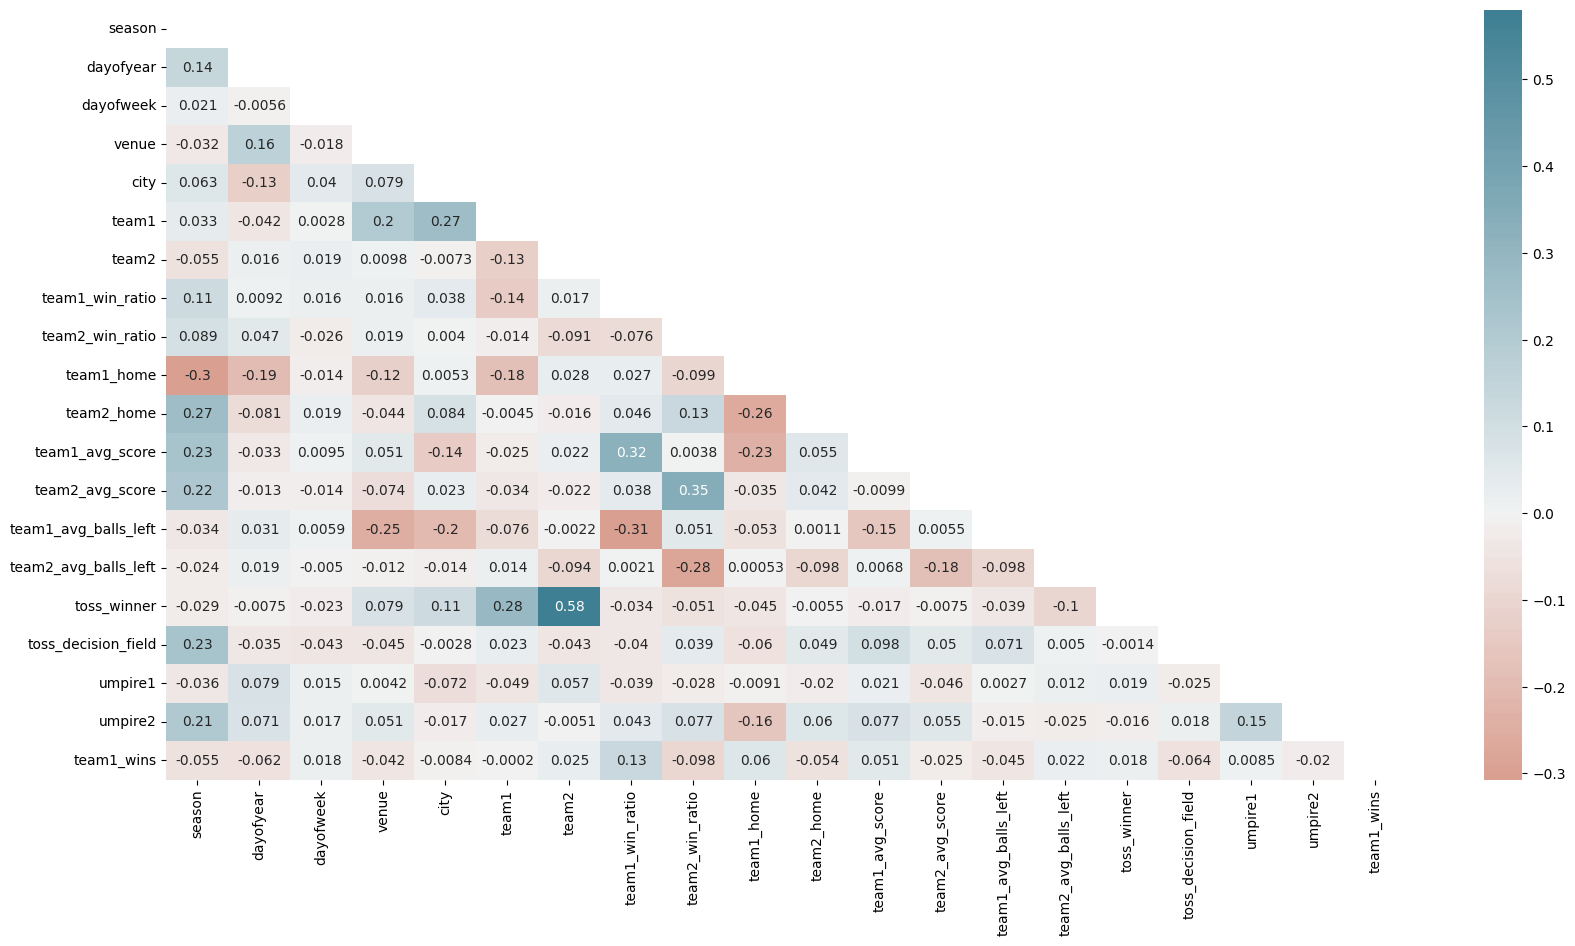

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_matrix = mdf.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

# Splitting the dataset

In [ ]:
X = mdf.drop(columns=['team1_wins'])
y = mdf['team1_wins']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-Validation on different models

### ExtraTreesClassifier
Finding the best parameters for ExtraTreesClassifier using RandomizedSearchCV

In [ ]:
et = ExtraTreesClassifier(n_estimators=100, min_samples_split=3, min_samples_leaf=3, max_depth=8, bootstrap=False)

param_dist = {
    'n_estimators': [100, 250, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [False, True]
}

random_search_et = RandomizedSearchCV(estimator=et, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=3)

random_search_et.fit(X_train, y_train)

# et.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=ExtraTreesClassifier(max_depth=8,
                                                  min_samples_leaf=3,
                                                  min_samples_split=3),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [None, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 250, 500, 1000]},
                   random_state=42, verbose=3)

In [ ]:
print(f"Best parameters: {random_search_et.best_params_}")
print(f"Best cross-validation score: {random_search_et.best_score_}")

best_model_et = random_search_et.best_estimator_
test_score = best_model_et.score(X_test, y_test)
print(f"Test set score: {test_score}")

Best parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best cross-validation score: 0.5729933481152993
Test set score: 0.5194174757281553


In [ ]:
y_pred = best_model_et.predict(X_test)
y_pred_proba = best_model_et.predict_proba(X_test)

In [ ]:
print('ATrS:', best_model_et.score(X_train, y_train))
print('ATeS:', best_model_et.score(X_test, y_test))
print(classification_report(y_test, y_pred))

ATrS: 0.8965936739659367
ATeS: 0.5194174757281553
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       105
           1       0.51      0.60      0.55       101

    accuracy                           0.52       206
   macro avg       0.52      0.52      0.52       206
weighted avg       0.52      0.52      0.52       206



### XGBClassifier
Finding the best parameters for XGBClassifier using RandomizedSearchCV

In [ ]:
xgb = XGBClassifier()

param_dist = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [3, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}

random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1, verbose=3)

random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 6, 7],
                                        'n_estimators': [100, 250, 500, 1000]},
                   random_state=42, verbose=3)

In [ ]:
print(f"Best parameters: {random_search_xgb.best_params_}")
print(f"Best cross-validation score: {random_search_xgb.best_score_}")

best_model_xgb = random_search_xgb.best_estimator_
test_score = best_model_xgb.score(X_test, y_test)
print(f"Test set score: {test_score}")

Best parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01}
Best cross-validation score: 0.5547154471544715
Test set score: 0.5339805825242718


In [ ]:
y_pred = best_model_xgb.predict(X_test)
y_pred_proba = best_model_xgb.predict_proba(X_test)

In [ ]:
print('ATrS:', best_model_xgb.score(X_train, y_train))
print('ATeS:', best_model_xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred))

ATrS: 0.9002433090024331
ATeS: 0.5339805825242718
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       105
           1       0.52      0.59      0.56       101

    accuracy                           0.53       206
   macro avg       0.54      0.54      0.53       206
weighted avg       0.54      0.53      0.53       206



### LGBMClassifier
Finding the best parameters for LGBMClassifier using RandomizedSearchCV

In [ ]:
lgbm = LGBMClassifier()

param_dist = {
    'n_estimators': [100, 250, 500, 1000],
    'num_leaves': [10, 30, 70, 80],
    'max_depth': [3, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0.0, 0.1, 1.0],
    'reg_lambda': [0.0, 0.1, 1.0]
}

random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=3)

random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 422, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 822, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513382 -> initscore=0.053541
[LightGBM] [Info] Start training from score 0.053541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 6, 7],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'num_leaves': [10, 30, 70, 80],
                                        'reg_alpha': [0.0, 0.1, 1.0],
                                        'reg_lambda': [0.0, 0.1, 1.0]},
                   random_state=42, verbose=3)

In [ ]:
print(f"Best parameters: {random_search_lgbm.best_params_}")
print(f"Best cross-validation score: {random_search_lgbm.best_score_}")

best_model_lgbm = random_search_lgbm.best_estimator_
test_score = best_model_lgbm.score(X_test, y_test)
print(f"Test set score: {test_score}")

Best parameters: {'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 30, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}
Best cross-validation score: 0.5668144863266814
Test set score: 0.5097087378640777


In [ ]:
y_pred = best_model_lgbm.predict(X_test)
y_pred_proba = best_model_lgbm.predict_proba(X_test)

In [ ]:
print('ATrS:', best_model_lgbm.score(X_train, y_train))
print('ATeS:', best_model_lgbm.score(X_test, y_test))
print(classification_report(y_test, y_pred))

ATrS: 1.0
ATeS: 0.5097087378640777
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       105
           1       0.50      0.50      0.50       101

    accuracy                           0.51       206
   macro avg       0.51      0.51      0.51       206
weighted avg       0.51      0.51      0.51       206



In [ ]:
model = best_model_et # Change to whichever model gives best accuracy from the above three models.

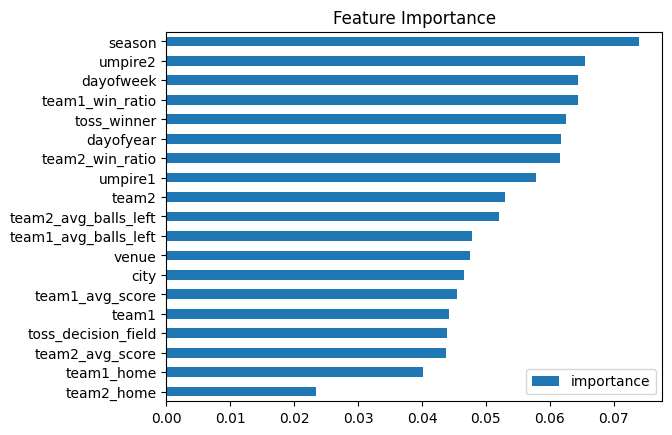

In [ ]:
fi = pd.DataFrame(data=model.feature_importances_, columns=['importance'])
fi.index = X.columns
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Testing the model on user input

In [ ]:
def process_test_data(df):
    df = df.copy()

    df['season'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.year
    df['dayofyear'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.dayofyear
    df['dayofweek'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.dayofweek
    df = df.drop(columns=['date'])

    df['team1_home'] = False
    df['team2_home'] = False

    df.loc[df['city'] == df['team1'], 'team1_home'] = True
    df.loc[df['city'] == df['team2'], 'team2_home'] = True

    df['team1_win_ratio'] = df['team1'].map(win_ratio)
    df['team2_win_ratio'] = df['team2'].map(win_ratio)

    df['team1_avg_score'] = df['team1'].map(avg_teams_score)
    df['team2_avg_score'] = df['team2'].map(avg_teams_score)
    df['team1_avg_balls_left'] = df['team1'].map(avg_teams_balls_left)
    df['team2_avg_balls_left'] = df['team2'].map(avg_teams_balls_left)

    df['team1'] = team_le.transform(df['team1'])
    df['team2'] = team_le.transform(df['team2'])
    df['city'] = team_le.transform(df['city'])
    df['toss_winner'] = team_le.transform(df['toss_winner'])

    df['venue'] = venue_le.transform(df['venue'])
    df['umpire1'] = umpire_le.transform(df['umpire1'])
    df['umpire2'] = umpire_le.transform(df['umpire2'])

    df = df.reindex(columns=['season', 'dayofyear', 'dayofweek', 'venue', 'city',
                           'team1', 'team2', 'team1_win_ratio', 'team2_win_ratio', 'team1_home', 'team2_home',
                           'team1_avg_score', 'team2_avg_score', 'team1_avg_balls_left', 'team2_avg_balls_left',
                           'toss_winner',  'toss_decision_field',
                           'umpire1', 'umpire2'])

    return df

In [ ]:
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
from datetime import datetime

teams = win_ratio.keys()
venues = mdf_clone['venue'].unique()
umpires = pd.concat([mdf_clone['umpire1'], mdf_clone['umpire2']]).unique()

stadium_city_map = {
        'M Chinnaswamy Stadium': 'Bangalore',
        'M Chinnaswamy Stadium, Bengaluru': 'Bangalore',
        'Punjab Cricket Association Stadium, Mohali': 'Mohali',
        'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Mohali',
        'Feroz Shah Kotla': 'Delhi',
        'Arun Jaitley Stadium': 'Delhi',
        'Arun Jaitley Stadium, Delhi': 'Delhi',
        'Wankhede Stadium': 'Mumbai',
        'Wankhede Stadium, Mumbai': 'Mumbai',
        'Eden Gardens': 'Kolkata',
        'Eden Gardens, Kolkata': 'Kolkata',
        'Sawai Mansingh Stadium': 'Jaipur',
        'Sawai Mansingh Stadium, Jaipur': 'Jaipur',
        'Rajiv Gandhi International Stadium, Uppal': 'Hyderabad',
        'Rajiv Gandhi International Stadium': 'Hyderabad',
        'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Hyderabad',
        'MA Chidambaram Stadium, Chepauk': 'Chennai',
        'MA Chidambaram Stadium': 'Chennai',
        'MA Chidambaram Stadium, Chepauk, Chennai': 'Chennai',
        'Dr DY Patil Sports Academy': 'Mumbai',
        'Dr DY Patil Sports Academy, Mumbai': 'Mumbai',
        'Newlands': 'Cape Town',
        "St George's Park": 'Port Elizabeth',
        'Kingsmead': 'Durban',
        'SuperSport Park': 'Centurion',
        'Buffalo Park': 'East London',
        'New Wanderers Stadium': 'Johannesburg',
        'De Beers Diamond Oval': 'Kimberley',
        'OUTsurance Oval': 'Bloemfontein',
        'Brabourne Stadium': 'Mumbai',
        'Brabourne Stadium, Mumbai': 'Mumbai',
        'Sardar Patel Stadium, Motera': 'Ahmedabad',
        'Barabati Stadium': 'Cuttack',
        'Vidarbha Cricket Association Stadium, Jamtha': 'Nagpur',
        'Himachal Pradesh Cricket Association Stadium': 'Dharamsala',
        'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'Dharamsala',
        'Nehru Stadium': 'Kochi',
        'Holkar Cricket Stadium': 'Indore',
        'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Visakhapatnam',
        'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam': 'Visakhapatnam',
        'Subrata Roy Sahara Stadium': 'Pune',
        'Maharashtra Cricket Association Stadium': 'Pune',
        'Maharashtra Cricket Association Stadium, Pune': 'Pune',
        'Shaheed Veer Narayan Singh International Stadium': 'Raipur',
        'JSCA International Stadium Complex': 'Ranchi',
        'Sheikh Zayed Stadium': 'Abu Dhabi',
        'Sharjah Cricket Stadium': 'Sharjah',
        'Dubai International Cricket Stadium': 'Dubai',
        'Saurashtra Cricket Association Stadium': 'Rajkot',
        'Green Park': 'Kanpur',
        'Narendra Modi Stadium, Ahmedabad': 'Ahmedabad',
        'Zayed Cricket Stadium, Abu Dhabi': 'Abu Dhabi',
        'Eden Gardens, Kolkata': 'Kolkata',
        'Punjab Cricket Association IS Bindra Stadium': 'Mohali',
        'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'Mohali',
        'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow': 'Lucknow',
        'Barsapara Cricket Stadium, Guwahati': 'Guwahati',
        'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur': 'Mullanpur'
}

date = widgets.DatePicker(description='Select a date', disabled=False)
venue = widgets.Dropdown(options=venues, description='Venue:')
team1 = widgets.Dropdown(options=teams, description='Team 1:')
team2 = widgets.Dropdown(options=teams, description='Team 2:')
toss_winner = widgets.Dropdown(options=teams, description='Toss Winner:')
toss_decision_field = widgets.Checkbox(value=False, description='Toss winner chose fielding?')
umpire1 = widgets.Dropdown(options=umpires, description='Umpire 1:')
umpire2 = widgets.Dropdown(options=umpires, description='Umpire 2:')

prediction_result = widgets.Output()

def handle_prediction(btn):
    with prediction_result:
        prediction_result.clear_output()
        if team1.value == team2.value:
            print("Team1 and team2 cannot be the same!")
            return
        if umpire1.value == umpire2.value:
            print("One person can't be both umpires!")
            return

        test_data = {
            'date': date.value,
            'venue': venue.value,
            'city': stadium_city_map[venue.value],
            'team1': team1.value,
            'team2': team2.value,
            'toss_winner': toss_winner.value,
            'toss_decision_field': toss_decision_field.value,
            'umpire1': umpire1.value,
            'umpire2': umpire2.value
        }

        if None in test_data.values():
            print("Please fill all fields.")
            return

        test_data_df = pd.Series(test_data).to_frame().T
        test_data_df = process_test_data(test_data_df)
        prediction = model.predict_proba(test_data_df)[0]
        print(f"Processed Test Data:\n{test_data_df}")
        print(f"Prediction: \n{team1.value} - {prediction[1]} \n{team2.value} - {prediction[0]}")

predict_button = widgets.Button(description='Predict')
predict_button.on_click(handle_prediction)

input_form = widgets.VBox([
    date, venue, team1, team2, toss_winner, toss_decision_field, umpire1, umpire2,
    predict_button, prediction_result
])

display(input_form)